# MVLidar First Architecture
Encoder:

- Three convolutional layers with 3x3 filters of 64, 64, and 128 in the input resolution (64x1024).
- Three Inception blocks at reduced resolutions (using max pooling for downsampling).
- The three Inception blocks consist of two, two, and three Inception modules, respectively.

Decoder:

- Three deconvolution blocks.
- Each block consists of a deconvolution layer followed by two convolution layers with 1x1 and 3x3 filters, respectively.
- The number of filters within these blocks (across all layers) is 256, 128, and 64, respectively.
- Skip connections are added at quarter and half resolutions.

Classification Head:

- Consists of a 3x3 convolutional layer with an output size of 64.
- Followed by a 1x1 layer that produces a vector of 7 elements per pixel indicating class probabilities.
- Each convolutional layer is followed by batch normalization and ReLU activation.
- Every convolutional layer is followed by batch normalization and ReLU activation.
- Input and output have the same resolution space.

In [ ]:
#| default_exp mvlidar_model

In [ ]:
#| export
import torch
import numpy as np
import torch.nn as nn
from torch.nn import ReLU
from torch.optim import Adam
from torch.nn import MaxPool2d
import torch.nn.functional as F

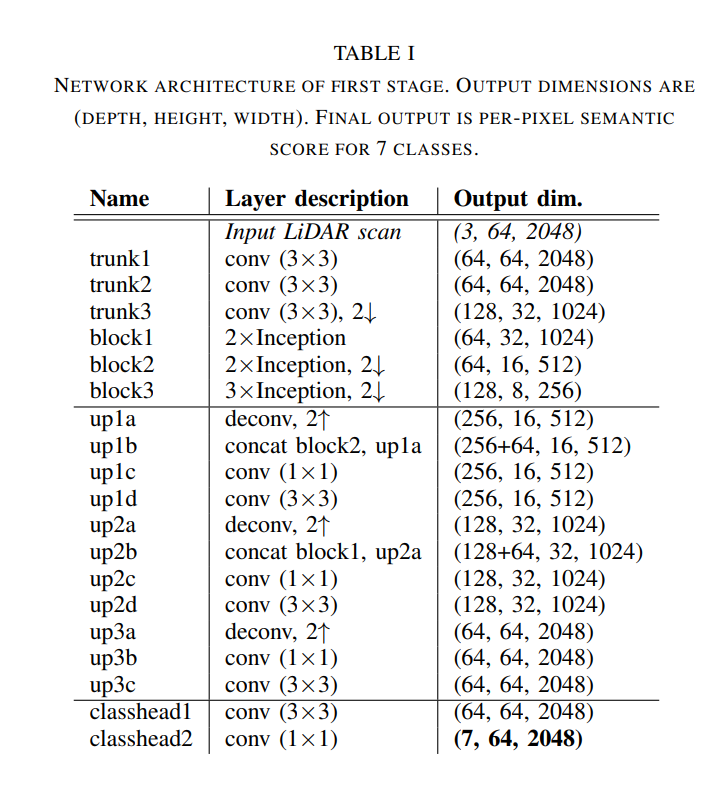

In [ ]:
#| export
class conv_Block(nn.Module):
  def __init__(self, in_channels , out_channels , kernel_size , stride=1 , padding=0):
    super(conv_Block , self).__init__()
    self.conv = nn.Conv2d(in_channels , out_channels , kernel_size , stride , padding)
    self.batchNormalization = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()

  def forward(self,x):
    out = self.conv(x)
    out = self.batchNormalization(out)
    out = self.activation(out)
    return out

In [ ]:
#| export
class Inception_2(nn.Module):
    """Inception_2 Block"""

    def __init__(self, in_channels, output_dim):
        super(Inception_2, self).__init__()

        # 1x1
        self.b1_1 = conv_Block(in_channels, output_dim, kernel_size=1, stride=1, padding=0)

        # pool -> 1x1
        self.b2_1 = nn.MaxPool2d(kernel_size=3 , stride=1 , padding=1)
        self.b2_2 = conv_Block(in_channels, output_dim, kernel_size=1, stride=1, padding=0)

        # 1x1 -> 3x3
        self.b3_1 = conv_Block(in_channels, output_dim, kernel_size=1, stride=1, padding=0)
        self.b3_2 = conv_Block(output_dim, output_dim, kernel_size=3, stride=1, padding=1)

        # 1x1 -> 3x3 -> 3x3
        self.b4_1 = conv_Block(in_channels, output_dim, kernel_size=1, stride=1, padding=0)
        self.b4_2 = conv_Block(output_dim, output_dim, kernel_size=3, stride=1, padding=1)
        self.b4_3 = conv_Block(output_dim, output_dim, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        branch1 = self.b1_1(x)

        branch2 = self.b2_1(x)
        branch2 = self.b2_2(branch2)

        branch3 = self.b3_1(x)
        branch3 = self.b3_2(branch3)

        branch4 = self.b4_1(x)
        branch4 = self.b4_2(branch4)
        branch4 = self.b4_3(branch4)

        return torch.cat((branch1, branch2, branch3, branch4), dim=1)

In [ ]:
#| export
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, output_dims, num_modules):
        super(InceptionBlock, self).__init__()
        self.modules_inBlock = nn.ModuleList([])
        for module in range(num_modules):
          self.modules_inBlock = self.modules_inBlock.append(Inception_2(in_channels[module], output_dims[module]))

    def forward(self, x):
        for module in self.modules_inBlock:
            x = module(x)
        return x

In [ ]:
#| export
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = conv_Block(2, 64, kernel_size=3, padding=1)
        self.conv2 = conv_Block(64, 64, kernel_size=3, padding=1)
        self.conv3 = conv_Block(64, 128, kernel_size=3, padding=1)

        self.pool = MaxPool2d(2)

        self.inception_block_1 = InceptionBlock(in_channels=(128,64), output_dims=(16,16), num_modules=2)
        self.inception_block_2 = InceptionBlock(in_channels=(64,64), output_dims=(16,16), num_modules=2)
        self.inception_block_3 = InceptionBlock(in_channels=(64,128,128), output_dims=(32, 32, 32), num_modules=3)

    def forward(self, x):
        x = self.conv1(x)

        x = self.conv2(x)

        x = self.conv3(x)
        x = self.pool(x)

        block1 = self.inception_block_1(x)

        block2 = self.pool(self.inception_block_2(block1))

        block3 = self.pool(self.inception_block_3(block2))

        return block1, block2, block3

In [ ]:
#| export
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv1 = conv_Block(320, 256, kernel_size=1)
        self.conv2 = conv_Block(256, 256, kernel_size=3, padding=1)

        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = conv_Block(192, 128, kernel_size=1)
        self.conv4 = conv_Block(128, 128, kernel_size=3, padding=1)

        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv5 = conv_Block(64, 64, kernel_size=1)
        self.conv6 = conv_Block(64, 64, kernel_size=3, padding=1)

        self.pool = MaxPool2d(2)


    def concat_block(self, input_tensor1, input_tensor2):
      # Concatenate along the first dimension
      concatenated_tensor = torch.cat([input_tensor1, input_tensor2], dim=1)

      return concatenated_tensor


    def deconvBlock1(self, x, block2):
      return self.conv2(self.conv1(self.concat_block(self.deconv1(x), block2)))

    def deconvBlock2(self, x, block1):
      return self.conv4(self.conv3(self.concat_block(self.deconv2(x), block1)))

    def deconvBlock3(self, x):
      return self.conv6(self.conv5(self.deconv3(x)))


    def forward(self, block1, block2, block3):
        x = self.deconvBlock1(block3, block2)
        x = self.deconvBlock2(x, block1)
        x = self.deconvBlock3(x)

        return x

In [ ]:
#| export
class MVLidar(nn.Module):
  def __init__(self, N_CLASSES):
    super().__init__()
    self.encoder = Encoder()

    self.decoder = Decoder()

    self.classhead1 = conv_Block(64, 64, kernel_size=3, padding=1)
    self.classhead2 = conv_Block(64, N_CLASSES, kernel_size=1)


  def forward(self, x):
    encFeatures1, encFeatures2, encFeatures3 = self.encoder(x)

    decFeatures = self.decoder(encFeatures1, encFeatures2, encFeatures3)

    x = self.classhead1(decFeatures)
    x = self.classhead2(x)

    return x

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()